In [3]:
# Tutorial 2: Single cell simulation with external feedfoward input (with BioNet)

In [2]:
from bmtk.builder.networks import NetworkBuilder

# 构建单个细胞组成的网络，步骤与Tutorial1相同
# 实例化
cortex = NetworkBuilder('mcortex')

# 添加单个节点
cortex.add_nodes(
    cell_name='Scnn1a_473845048',
    potental='exc',
    model_type='biophysical',
    model_template='ctdb:Biophys1.hoc',
    model_processing='aibs_perisomatic',
    dynamics_params='472363762_fit.json',
    morphology='Scnn1a_473845048_m.swc'
)

# 构建
cortex.build()

# 保存
cortex.save_nodes(output_dir='sim_ch02/network')

In [5]:
# 构建新网络，这是一个虚拟细胞，没有正常神经元的形态与特性，此处只充当一个脉冲发射器，表示来自丘脑的输入
# 实例化
thalamus = NetworkBuilder('mthalamus')

# 添加10个节点（N=10）
thalamus.add_nodes(
    N=10,
    pop_name='tON',
    potential='exc',
    model_type='virtual'  # 不再是生物物理细胞（'biophysical'），而是虚拟细胞（'virtual'）
)

In [6]:
# 连接两个网络，方法是添加边（edges）
thalamus.add_edges(
    # 设置source和target
    source={'pop_name': 'tON'},   # 设置起始节点
    # source=thalamus.nodes(),  # 这样写也可以
    target=cortex.nodes(),  # 设置目标节点
    
    # 设置突触个数
    connection_rule=5,  # 表示source和target节点之间有5个突触
    
    # 权重
    syn_weight=0.001,  # 连接强度
    delay=2.0,  # 连接延迟是2ms
    weight_function=None,  # 用于调整权重
    
    # 决定在突触后神经元的哪个位置设置突触，默认情况下是在给定部分和距离范围内随机
    target_sections=['basal', 'apical'],  # 给定部分
    distance_range=[0.0, 150.0],  # 距离范围
    
    # 参数文件
    dynamics_params='AMPA_ExcToExc.json',
    model_template='exp2syn'
)

In [7]:
# 构建
thalamus.build()

# 保存节点
thalamus.save_nodes(output_dir='sim_ch02/network')

# 保存边
thalamus.save_edges(output_dir='sim_ch02/network')

In [8]:
# 因为节点文件和边文件分开来存储，所以后续重建、修改等工作就方便很多了

In [9]:
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator

# 建立尖峰队列（Spike Train），按泊松分布（Poisson）
psg = PoissonSpikeGenerator(population='mthalamus')
psg.add(
    node_ids=range(10),  # 10个与mthalamus（先前创建的虚拟细胞）对应的节点
    firing_rate=10.0,    # 发放的速率为10赫兹，这里也可以传入函数或数组
    times=(0.0, 3.0)    # 发放从0秒到3秒开始
)

# 保存为Sonata格式的队列（除了.h5以外，BMTK也允许存为csv或NWB文件）
psg.to_sonata('sim_ch02/inputs/mthalamus_spikes.h5')

In [10]:
# 打印参数
print('Number of spikes: {}'.format(psg.n_spikes()))
print('Units: {}'.format(psg.units()))

psg.to_dataframe().head()

Number of spikes: 299
Units: ms


,node_ids,timestamps,population
0,0,91.110410,mthalamus
1,0,152.574983,mthalamus
2,0,155.663408,mthalamus
3,0,317.988328,mthalamus
4,0,545.893875,mthalamus


In [14]:
# Step 2: Setting up BioNet environment.
# 在运行模拟器之前，需要先创建运行时环境，即程序运行时为其提供所需资源的软件环境，包括操作系统、库函数、配置文件等

In [13]:
from bmtk.utils.sim_setup import build_env_bionet

# 参数与Tutorial1中学习到的差不多，此处不写注释（保留原文档给出的英文注释）
build_env_bionet(
    base_dir='sim_ch02',
    config_file='config.json',
    network_dir='sim_ch02/network',
    tstop=3000.0, dt=0.1,
    report_vars=['v', 'cai'],    # Record membrane potential and calcium (default soma)
    spikes_inputs=[('mthalamus', # Name of population which spikes will be generated for
                    'sim_ch02/inputs/mthalamus_spikes.h5')],
    include_examples=True,       # Copies components files
    compile_mechanisms=True      # Will try to compile NEURON mechanisms
)

/home/tianyan/sim_ch02/components/mechanisms
Mod files: "modfiles/modfiles/CaDynamics.mod" "modfiles/modfiles/Ca_HVA.mod" "modfiles/modfiles/Ca_LVA.mod" "modfiles/modfiles/Ih.mod" "modfiles/modfiles/Im.mod" "modfiles/modfiles/Im_v2.mod" "modfiles/modfiles/Kd.mod" "modfiles/modfiles/K_P.mod" "modfiles/modfiles/K_T.mod" "modfiles/modfiles/Kv2like.mod" "modfiles/modfiles/Kv3_1.mod" "modfiles/modfiles/Nap.mod" "modfiles/modfiles/NaTa.mod" "modfiles/modfiles/NaTs.mod" "modfiles/modfiles/NaV.mod" "modfiles/modfiles/SK.mod" "modfiles/modfiles/vecevent.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../modfiles/CaDynamics.mod
 -> NMODL ../modfiles/Ca_HVA.mod
 -> NMODL ../modfiles/Ca_LVA.mod
 -> NMODL ../modfiles/Ih.mod
 -> NMODL ../modfiles/Im.mod
 -> NMODL ../modfiles/Im_v2.mod
 -> NMODL ../modfiles/Kd.mod
 -> NMODL ../modfiles/K_P.mod
 -> NMODL ../modfiles/K_T.mod
 -> NMODL ../modfiles/Kv2like.mod
 -> NMODL ../modfiles/Kv3_1.mod
 -> NMODL ../modfiles/Nap

Translating Ca_LVA.mod into /home/tianyan/sim_ch02/components/mechanisms/x86_64/Ca_LVA.c
Translating CaDynamics.mod into /home/tianyan/sim_ch02/components/mechanisms/x86_64/CaDynamics.c
Translating Ca_HVA.mod into /home/tianyan/sim_ch02/components/mechanisms/x86_64/Ca_HVA.c
Thread Safe
Thread Safe
Thread Safe
Translating Ih.mod into /home/tianyan/sim_ch02/components/mechanisms/x86_64/Ih.c
Translating Im_v2.mod into /home/tianyan/sim_ch02/components/mechanisms/x86_64/Im_v2.c
Translating Im.mod into /home/tianyan/sim_ch02/components/mechanisms/x86_64/Im.c
Thread Safe
Thread Safe
Thread Safe
Translating Kd.mod into /home/tianyan/sim_ch02/components/mechanisms/x86_64/Kd.c
Translating K_P.mod into /home/tianyan/sim_ch02/components/mechanisms/x86_64/K_P.c
Translating K_T.mod into /home/tianyan/sim_ch02/components/mechanisms/x86_64/K_T.c
Thread Safe
Thread Safe
Thread Safe
Translating Kv2like.mod into /home/tianyan/sim_ch02/components/mechanisms/x86_64/Kv2like.c
Translating Kv3_1.mod into /ho

 -> Compiling CaDynamics.c
 -> Compiling Ca_HVA.c
 -> Compiling Ca_LVA.c
 -> Compiling Ih.c
 -> Compiling Im.c
 -> Compiling Im_v2.c
 -> Compiling Kd.c
 -> Compiling K_P.c
 -> Compiling K_T.c
 -> Compiling Kv2like.c
 -> Compiling Kv3_1.c
 -> Compiling Nap.c
 -> Compiling NaTa.c
 -> Compiling NaTs.c
 -> Compiling NaV.c
 -> Compiling SK.c
 -> Compiling vecevent.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special


/opt/conda/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


In [15]:
from bmtk.simulator import bionet

# 运行模拟器
conf = bionet.Config.from_json('sim_ch02/config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

# 打印
print('Success!')

2023-07-25 11:14:25,210 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


numprocs=1
2023-07-25 11:14:25,291 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2023-07-25 11:14:25,366 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2023-07-25 11:14:25,368 [INFO] Building virtual cell stimulations for mthalamus_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for mthalamus_spikes


2023-07-25 11:14:25,388 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 3000.000 ms with the time step 0.100 ms


2023-07-25 11:14:25,389 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2023-07-25 11:14:25,390 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2023-07-25 11:14:25,646 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2023-07-25 11:14:25,880 [INFO]     step:10000 t_sim:1000.00 ms


INFO:NEURONIOUtils:    step:10000 t_sim:1000.00 ms


2023-07-25 11:14:26,131 [INFO]     step:15000 t_sim:1500.00 ms


INFO:NEURONIOUtils:    step:15000 t_sim:1500.00 ms


2023-07-25 11:14:26,368 [INFO]     step:20000 t_sim:2000.00 ms


INFO:NEURONIOUtils:    step:20000 t_sim:2000.00 ms


2023-07-25 11:14:26,617 [INFO]     step:25000 t_sim:2500.00 ms


INFO:NEURONIOUtils:    step:25000 t_sim:2500.00 ms


2023-07-25 11:14:26,864 [INFO]     step:30000 t_sim:3000.00 ms


INFO:NEURONIOUtils:    step:30000 t_sim:3000.00 ms


2023-07-25 11:14:26,879 [INFO] Simulation completed in 1.491 seconds 


INFO:NEURONIOUtils:Simulation completed in 1.491 seconds 


Success!


In [16]:
from bmtk.analyzer.spike_trains import to_dataframe

# 分析运行结果
results_df = to_dataframe(config_file='sim_ch02/config.json')
print('Number of Spikes: {}'.format(len(results_df)))
results_df.head()

Number of Spikes: 53


,timestamps,node_ids,population
0,100.5,0,mcortex
1,1835.1,0,mcortex
2,1971.0,0,mcortex
3,2016.1,0,mcortex
4,2051.2,0,mcortex


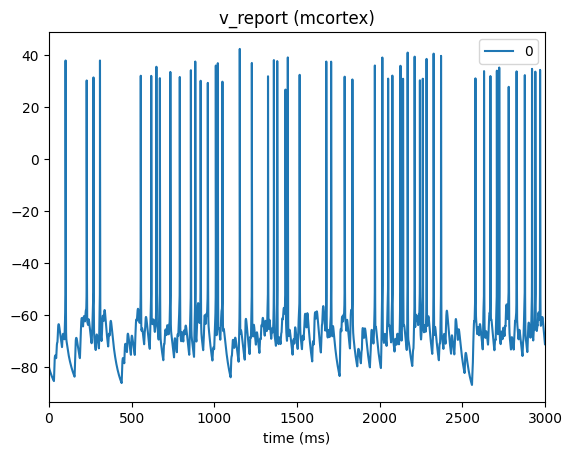

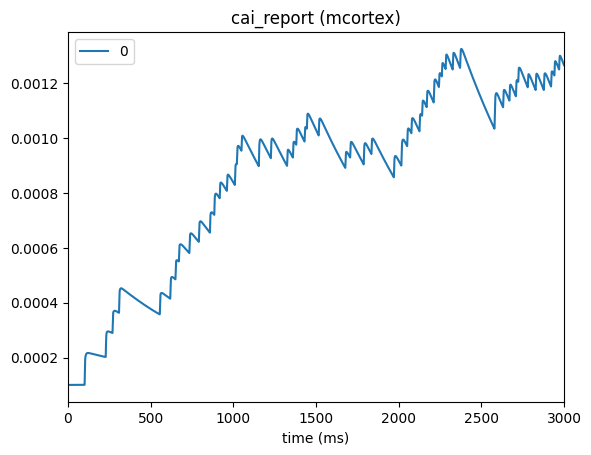

In [17]:
from bmtk.analyzer.compartment import plot_traces

_ = plot_traces(config_file='sim_ch02/config.json', node_ids=[0], report_name='v_report')
_ = plot_traces(config_file='sim_ch02/config.json', node_ids=[0], report_name='cai_report')